# Fit Rankine, Holland, Willoughby and Chavas profiles on SAR data
Note that so far the Rmax is searched in the first 200km around the TC center (in the code this impacts how the functions are initialized, but also when the curves are plot (on the smaller scale graph).

For the fitting, we constrain Rmax > 5km which works well for a lot of TCs. 

In the papers of Holland, Willoughby and Chavas, the wind used is the tangential wind (same for Rankine). 

TODO:

==> Which profiles work when? etc...



In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from scipy.optimize import curve_fit

import glob

import functions as f

In [2]:
### PATHS
# dir_path = '/home/arthur/data/cyclobs/rotated_files/'
dir_path = '/home/arthur/data/cyclobs/rotated_files/clean_dataset/'
all_data = glob.glob(dir_path + "*.nc")
print("Total number of files:", len(all_data))
# Savepath to be modified directly in the function

### PARAMS
PARAMS = {
    'r_window_len':          501,  # Scale for radius (km)
    'rmax_window':           300,  # Window in whick we look for Rmax (e.g [0, 200km])
    'chavas_vfit':           17,
    'rank_hol_will_vmin':    True, # Uses Vmin as a free parameter if True. If False, Vmin = 0
    'chavas_vmin':           False, # Translates the profile from Vmin if True
    
    'r_Rmax_axis':           True, # If True, uses r* = r/Rmax as x-axis
    'r_Rmax_scale':          16.,
    'r_Rmax_num_pts':        321,
    
    'use_curve_fit':         True,
    'tangential_wind_speed': True, # If False, total wind speed is used
    'print_values':          False, 
    
    'save_dir':              "/home/arthur/results/windProfiles/test7/",
    'save_comparison':       False,
    'save_scatter':          False
    }

Total number of files: 322


In [3]:
# INITIALIZE DATA STRUCTURE
INI = {           # Initial values
    'Rankine':    [], # x, alpha, Vmin, Rmax
    'Holland':    [], # Lat, pn, pc, Vmin, Rmax, Vmax
    'Willoughby': [], # n, X1, Vmin, Rmax, Vmax
    'Chavas':     []  # Vmax, Vmin, Rfit, Vfit, fcor, Cdvary, Cd, w_cool, CkCdvary, CkCd, eye_adj, alpha_eye
    } 
FIT = {           # Fit values
    'Rankine':    [], # x, alpha, Vmin, Rmax
    'Holland':    [], # Lat, pn, pc, Vmin, Rmax, Vmax
    'Willoughby': [], # n, X1, Vmin, Rmax, Vmax
    'Chavas':     []  # rr, VV, rmax, r0, rmerge, Vmerge
    }
# GAP WITH OBSERVATIONS
NB_CAT    = [None] * 6
DIFF      = [None] * 6
RMAX_OBS  = [None] * 6
RMAX_FIT  = [None] * 6
VMAX_OBS  = [None] * 6
VMAX_FIT  = [None] * 6
FIT_PARAMS= [None] * 6
r_axis_length = PARAMS['r_window_len']
if PARAMS['r_Rmax_axis']:
    r_axis_length = PARAMS['r_Rmax_num_pts']
for i in range(6):
    # DIFF[0] = Storm
    # DIFF[i] = Cat. i
    DIFF[i] = {
    'Rankine':    [0.] * r_axis_length,
    'Holland':    [0.] * r_axis_length,
    'Willoughby': [0.] * r_axis_length,
    'Chavas':     [0.] * r_axis_length 
    }
    NB_CAT[i] = {
    'Rank-Hol-Will': [0.] * r_axis_length,
    'Chavas':        [0.] * r_axis_length 
    }
    RMAX_OBS[i] = []
    RMAX_FIT[i] = {
    'Rankine':    [],
    'Holland':    [],
    'Willoughby': [],
    'Chavas':     [] 
    }
    VMAX_OBS[i] = []
    VMAX_FIT[i] = {
    'Rankine':    [],
    'Holland':    [],
    'Willoughby': [],
    'Chavas':     [] 
    }
    FIT_PARAMS[i] = {
    'Rankine':    [],
    'Holland':    [],
    'Willoughby': [],
    'Chavas':     [] 
    }

1 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1b-ew-owi-cm-20180902t143708-20180902t143912-000003-01720F_ll_gd_rotated.nc


/home/arthur/scripts/windProfiles/symmetric/functions.py:274: RuntimeWarning: divide by zero encountered in true_divide
  V_ER11 = (1. / rr_ER11) * (Vmax * rmax + .5 * fcor * rmax ** 2) * ((2 * (rr_ER11 / rmax) ** 2) / (2 - CkCd + CkCd * (rr_ER11 / rmax) ** 2)) ** (1 / (2 - CkCd)) - .5 * fcor * rr_ER11
/home/arthur/scripts/windProfiles/symmetric/functions.py:274: RuntimeWarning: invalid value encountered in multiply
  V_ER11 = (1. / rr_ER11) * (Vmax * rmax + .5 * fcor * rmax ** 2) * ((2 * (rr_ER11 / rmax) ** 2) / (2 - CkCd + CkCd * (rr_ER11 / rmax) ** 2)) ** (1 / (2 - CkCd)) - .5 * fcor * rr_ER11
/home/arthur/scripts/windProfiles/symmetric/functions.py:188: RuntimeWarning: invalid value encountered in true_divide
  VV = (Mm / rmax) * (MMfracMm / rrfracrm) - .5 * fcor * rmax * rrfracrm #[ms-1]


2 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/rs2--owi-cm-20150601t015945-20150601t020101-00003-BDBF8_ll_gd_rotated.nc
3 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1a-ew-owi-cm-20160827t092124-20160827t092414-000003-014249_ll_gd_rotated.nc
4 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1a-ew-owi-cm-20170207t015253-20170207t015558-000003-018D33_ll_gd_rotated.nc
5 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/rs2--owi-cm-20150509t232412-20150509t232525-00003-E0BD7_ll_gd_rotated.nc


/home/arthur/scripts/windProfiles/symmetric/functions.py:639: RuntimeWarning: Mean of empty slice
  spdm   = np.nanmean(spd, axis=0)


6 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1a-ew-owi-cm-20181002t211106-20181002t211310-000003-029DF5_ll_gd_rotated.nc
7 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1a-iw-owi-cm-20170504t071401-20170504t071505-000003-01B35C_ll_gd_rotated.nc
8 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1b-ew-owi-cm-20191106t194803-20191106t195007-000003-02377F_ll_gd_rotated.nc
9 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1a-iw-owi-cm-20170921t224421-20170921t224626-000003-01F204_ll_gd_rotated.nc
10 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1b-ew-owi-cm-20190428t122321-20190428t122602-000003-01E172_ll_gd_rotated.nc
0.8891109837498951
0.24197026748493078
0.9042900132514808
0.8459810324188695
[25, 41, 48, 29, 32, 34, 21, 21, 73, 16]


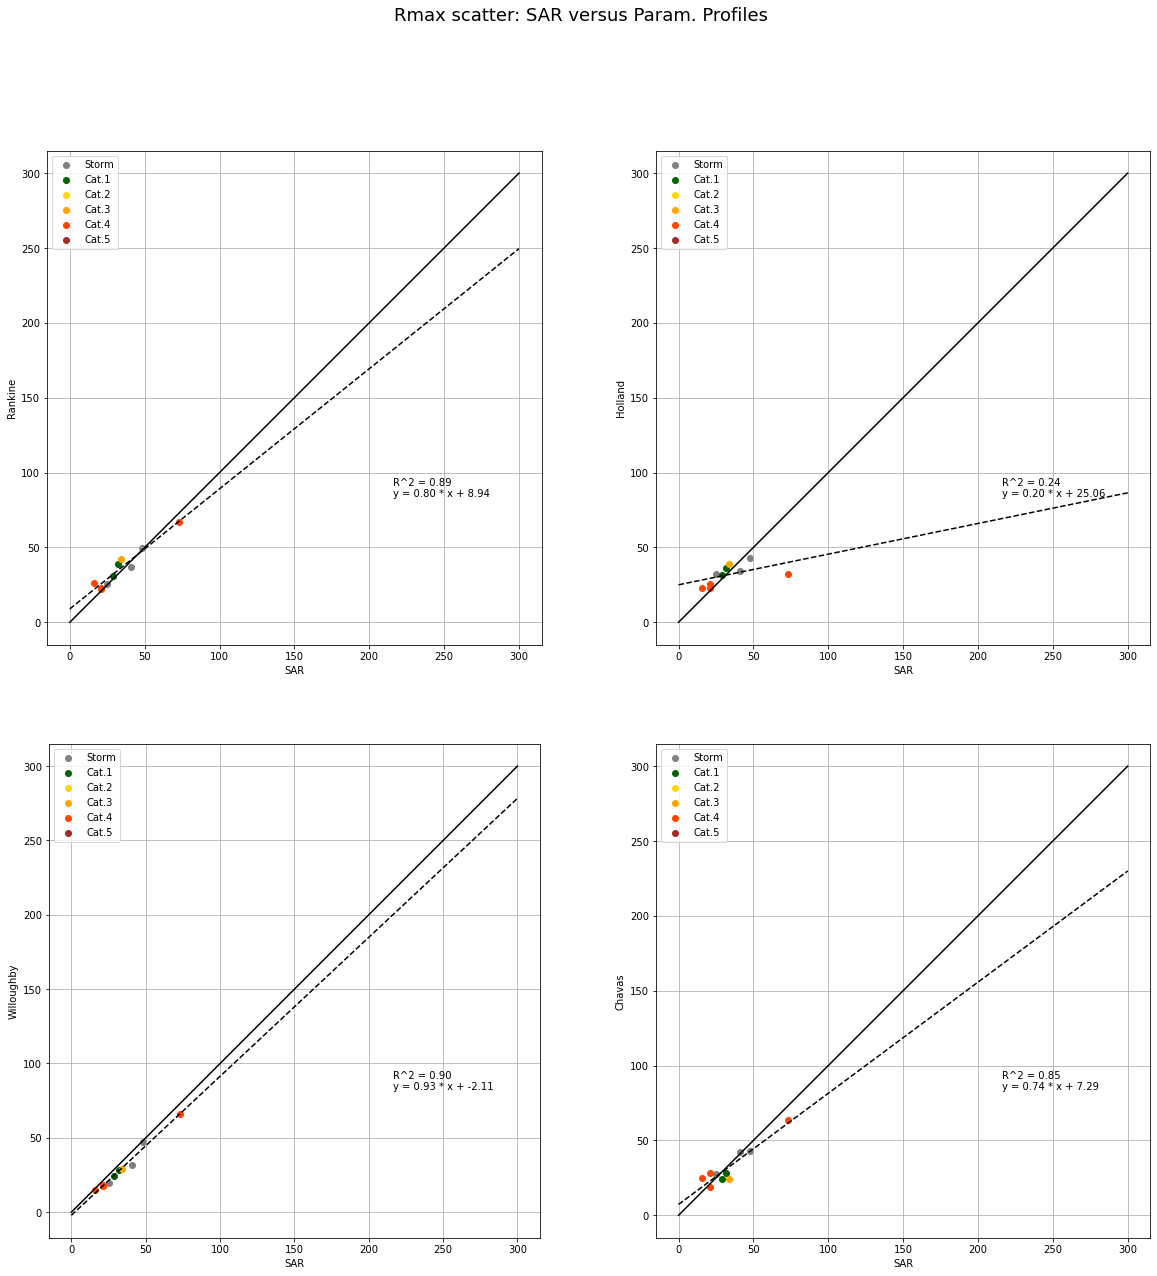

In [4]:
### ======================= WITHOUT QUADRANT ======================= 
# FIT AND PRINT ALL THE PROFILES ON ALL THE DATA
i   = 0
for file in all_data[:10]:
    i += 1
    print(i, "=>    ", file)
    # Open file and compute mean wind speed
    ds      = xr.open_dataset(file)
    if PARAMS['tangential_wind_speed']:
        spdm = f.compute_mean_tangential_wind_spd(ds, r_window_len=PARAMS['r_window_len']) # TANGENTIAL WIND SPEED
    else:
        spdm = f.compute_mean_wind_spd(ds, r_window_len=PARAMS['r_window_len'])            # TOTAL WIND SPEED
    
    # Debug
    if 1 == 0: # DEBUG
        f.print_ds(ds)
        f.print_spd(ds)
        print(spdm)
    
    # Initialize and fit profile
    r, spdm, first_valid_index = f.initialize_radius(spdm)
    
    INI['Rankine']    = f.initialize_rankine(spdm, x=0.5, alpha=1.,                                PARAMS=PARAMS)
    INI['Holland']    = f.initialize_holland(spdm, Lat=np.float64(ds['lat_ref']), pn=1005, pc=950, PARAMS=PARAMS)
    INI['Willoughby'] = f.initialize_willoughby(spdm, n=1.,                                        PARAMS=PARAMS)
    INI['Chavas']     = f.initialize_chavas(spdm, Lat=np.float64(ds['lat_ref']),                   PARAMS=PARAMS)
    
    FIT['Rankine']    = f.fit_rankine(r, spdm, *INI['Rankine'],                 PARAMS=PARAMS)
    FIT['Holland']    = f.fit_holland(r, spdm, *INI['Holland'],                 PARAMS=PARAMS)
    FIT['Willoughby'] = f.fit_willoughby_no_smooth(r, spdm, *INI['Willoughby'], PARAMS=PARAMS)
    FIT['Chavas']     = f.fit_chavas(*INI['Chavas'],                            PARAMS=PARAMS)
    
    Rmax, Vmax = INI['Holland'][4], INI['Holland'][5]
    
    # Comparison by category, function of r_star
    DIFF, NB_CAT = f.calculate_diff_by_cat(ds['current_category'], Rmax, r, spdm, INI, FIT, DIFF, NB_CAT, PARAMS)
    # Compute mean fitted parameters by category
    FIT_PARAMS   = f.calculate_fitted_params_by_cat(ds['current_category'], FIT, FIT_PARAMS, PARAMS)
    # Scater-plots
    RMAX_OBS, RMAX_FIT, VMAX_OBS, VMAX_FIT = f.add_to_scatter_list(ds['current_category'], r, Rmax, Vmax, FIT, RMAX_OBS, RMAX_FIT, VMAX_OBS, VMAX_FIT, PARAMS)

### Plot the comparison
# f.plot_comp_by_cat(DIFF, NB_CAT, PARAMS, save=PARAMS['save_comparison'])
# f.plot_fitted_params_by_cat(FIT_PARAMS, PARAMS)
f.plot_scatter_rmax(RMAX_OBS, RMAX_FIT, PARAMS)
# f.plot_scatter_vmax(VMAX_OBS, VMAX_FIT, PARAMS)

In [5]:
a = np.array([0.8, 0.9, 0.9, 1.1, 1.2, 1.5, 1.7, 1.9, 2.1, 2.3])
b = [np.argwhere(a > i)[0] for i in range(0, 3)]
b

[array([0]), array([3]), array([8])]

In [6]:
cat = np.array(ds['current_category'])
print(cat)
test = str(cat)
aa = [i for i in test]
print(aa)

cat-1
['c', 'a', 't', '-', '1']


In [7]:
print(ds)

<xarray.Dataset>
Dimensions:                             (lat: 1000, lon: 1000, x: 1000, y: 1000)
Coordinates:
    x_coords                            (x, y) int64 ...
    y_coords                            (x, y) int64 ...
    r_polar                             (x, y) float64 707.1 706.4 ... 705.7
    theta                               (x, y) float64 5.498 5.497 ... 2.356
    lon_coords                          (lon, lat) float64 ...
    lat_coords                          (lon, lat) float64 ...
Dimensions without coordinates: lat, lon, x, y
Data variables:
    incidence_angle                     (x, y) float32 ...
    wind_speed                          (x, y) float32 nan nan nan ... nan nan
    heterogeneity_mask                  (x, y) float32 ...
    elevation_angle                     (x, y) float32 ...
    heading_angle                       (x, y) float32 ...
    wind_streaks_orientation_stddev     (x, y) float32 ...
    nrcs_detrend_cross                  (x, y) float32 ...

In [8]:
r_star = np.linspace(0., 8., num=321)
r_star

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  ,
       1.125, 1.15 , 1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325,
       1.35 , 1.375, 1.4  , 1.425, 1.45 , 1.475, 1.5  , 1.525, 1.55 ,
       1.575, 1.6  , 1.625, 1.65 , 1.675, 1.7  , 1.725, 1.75 , 1.775,
       1.8  , 1.825, 1.85 , 1.875, 1.9  , 1.925, 1.95 , 1.975, 2.   ,
       2.025, 2.05 , 2.075, 2.1  , 2.125, 2.15 , 2.175, 2.2  , 2.225,
       2.25 , 2.275, 2.3  , 2.325, 2.35 , 2.375, 2.4  , 2.425, 2.45 ,
       2.475, 2.5  , 2.525, 2.55 , 2.575, 2.6  , 2.625, 2.65 , 2.675,
       2.7  , 2.725, 2.75 , 2.775, 2.8  , 2.825, 2.85 , 2.875, 2.9  ,
       2.925, 2.95 , 2.975, 3.   , 3.025, 3.05 , 3.075, 3.1  , 3.125,
       3.15 , 3.175,

In [9]:
r2 = 1.002355765
st = 'R^2 = {:.2f}'.format(r2)